In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
#!{sys.executable} -m pip install pandas-profiling
#import pandas_profiling as pp

Verilerimi birleştirdim EDA (Veri Keşfi ve Analizi) kısmına geçtim ve pandas profiling kullanarak korelasyon, eksik değerler ve diğer istatistiklere baktım.

Eksik değerlerin 1 er tane oldugunu ve "arrival delay in minute" sütununda 393 tane olduğunu gözlemledim. Eksik değerleri mod (en sık görülen değer) ile doldurdum. "Arrival delay" ile "departure delay" arasındaki korelasyon çok yüksek olduğu için "arrival delay" sütununu sildim, çünkü aynı bilgiyi taşıyorlardı.

"Gender" ve "type of travel" sütunlarını get dummies ile encode ettim (one-hot encoding).

Aykırı değerlere baktım, herhangi bir sorun görünmedi.

Daha sonra kategorik olmayan değerleri ayırdım ve seaborn kütüphanesinde boxplot kullanarak ilişkilerini inceledim.

Random Forest Classifier kullanarak modelimi eğittim, ancak uzun sürdü.

Bu nedenle feature importance (önemli değişkenlerin belirlenmesi) yöntemiyle modeldeki değişkenlerin katkılarını inceledim.

En çok katkı sağlayan 7 değişkeni seçerek modeli tekrar eğittim ve model eğitim süresi 3 kat daha hızlandı, ancak doğruluk (accuracy) değeri sadece 0.03 düştü.

## DATA LOADING

In [67]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = df_train.append(df_test, ignore_index=True)
df

<ipython-input-67-0deef5405a61>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_train.append(df_test, ignore_index=True)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,25971,78463,Male,disloyal Customer,34,Business travel,Business,526,3,3,...,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
129876,25972,71167,Male,Loyal Customer,23,Business travel,Business,646,4,4,...,4,4,5,5,5,5,4,0,0.0,satisfied
129877,25973,37675,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,...,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
129878,25974,90086,Male,Loyal Customer,14,Business travel,Business,1127,3,3,...,4,3,2,5,4,5,4,0,0.0,satisfied


## EDA


In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [69]:
df_train.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [70]:
#profile = pp.ProfileReport(df_train)
#profile.to_file('PandasProfile.html')

In [71]:
# Unnamed: 0	 silinmeli index ile ayni degerlere sahip
# corr map e bakildiginda id nin bir seyi etkilemedigi gozukmekte silinmeli
# gender in da hic etkisi yol silinmeli
# customer type 2 unique degere sahip encode edilmeli
# yas icin outler degerler
# type of travel kullanilmali bos deger yok ve 2 cesiti var encode edilmeli
# class ile type of travel arasinda corr cok yuksek bir tanesi kullanilabilir sadece class kullanilmasini oneririm
# flight distance kullanilabilir corr iyi durumda min max degerleri biraz tuhaf geldi onlar kontrol edilmeli
# inflight wifi kesinlikle kullanilmali corr cok iyi 0dan 6 ya kadqar numarlar var bir sorun gozukmuyor
# Departure/Arrival time convenient	 satisfaction i hic etkilememis ama diger feature lar ile corr var
# Ease of Online booking  kullanilabiliur bos degeri yok scale edilmeli sadece
# gate location etkisi az 1 tane missing degere sahip
# food and dring kullanilabilir bos deger de 1 tane var
# online boarding kullan 1 tane bos var corr iyi
# seat comfort etkiliyor
# inflight iyi boslar doldurulmali
# on-board services  kullanilmali bos deger var 1 tane
# leg room services kullanilmali 1 tane bos deger var
# Baggage handling kullanilabilir
# Checkin service kullan
# inflight kullan
# Cleanliness  kullan
# Departure Delay in Minutes hic etkisi yok ama ve Arrival Delay ile ayni degerlere sahip


## Preprocessing

In [72]:
df.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction    

In [73]:
df.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction    

In [74]:
df['Checkin service'].value_counts()
df['Arrival Delay in Minutes'].value_counts()


0.0      72753
1.0       2747
2.0       2587
3.0       2442
4.0       2373
         ...  
604.0        1
457.0        1
459.0        1
502.0        1
333.0        1
Name: Arrival Delay in Minutes, Length: 472, dtype: int64

In [75]:
df['Checkin service'].fillna(df['Checkin service'].value_counts().index[0], inplace=True)
df['Inflight service'].fillna(df['Inflight service'].value_counts().index[0], inplace=True)
df['Cleanliness'].fillna(df['Cleanliness'].value_counts().index[0], inplace=True)
df['Departure Delay in Minutes'].fillna(df['Departure Delay in Minutes'].value_counts().index[0], inplace=True)
df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].value_counts().index[0], inplace=True)
df['satisfaction'].fillna(df['satisfaction'].value_counts().index[0], inplace=True)


In [76]:
df.isna().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [77]:
df.drop(columns = ['Unnamed: 0','id'],inplace=True)


In [78]:
gender_dummies =  pd.get_dummies(df['Gender'],prefix = 'Gender')


In [79]:
df1 = df.iloc[:,:1]

df1 = pd.concat([df1,gender_dummies],axis=1)


In [80]:
df1 =df1.drop(columns='Gender')



In [81]:
df2 = df.iloc[:,1:]



In [82]:
df = pd.concat([df1,df2],axis = 1)


In [83]:
df = df.drop(df[df['Customer Type'] == 'Loy'].index)


In [84]:
df['Customer Type'].unique()

array(['Loyal Customer', 'disloyal Customer'], dtype=object)

In [85]:
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':2,'disloyal Customer':1})


In [86]:
df['Class'].unique()

array(['Eco Plus', 'Business', 'Eco'], dtype=object)

In [87]:
df['Class'] = df['Class'].map({'Eco Plus':2,'Business':3,'Eco':1})


In [88]:
df['Type of Travel'].isna().sum()

0

In [89]:
travel_dummies = pd.get_dummies(df['Type of Travel'],prefix = 'Travel')

df_dummies_right_side = df.iloc[:,5:]
df_dummies_left_size = df.iloc[:,:4]
concatted_dummies = pd.concat([df_dummies_left_size,travel_dummies],axis=1)
df = pd.concat([concatted_dummies,df_dummies_right_side],axis=1)
df

,Gender_Female,Gender_Male,Customer Type,Age,Travel_Business travel,Travel_Personal Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,1,2,13,0,1,2,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,0,1,1,25,1,0,3,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,1,0,2,26,1,0,3,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,1,0,2,25,1,0,3,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,0,1,2,61,1,0,3,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,0,1,1,34,1,0,3,526,3,3,...,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
129876,0,1,2,23,1,0,3,646,4,4,...,4,4,5,5,5,5,4,0,0.0,satisfied
129877,1,0,2,17,0,1,1,828,2,5,...,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
129878,0,1,2,14,1,0,3,1127,3,3,...,4,3,2,5,4,5,4,0,0.0,satisfied


In [90]:
df['satisfaction'].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

In [91]:
df['satisfaction'] = LabelEncoder().fit_transform(df['satisfaction'])


In [92]:
df['satisfaction'].unique()

array([0, 1])

In [93]:
df.drop(columns=['Arrival Delay in Minutes'],inplace=True)

In [94]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

,Gender_Female,Gender_Male,Customer Type,Age,Travel_Business travel,Travel_Personal Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,0,1,2,13,0,1,2,460,3,4,...,5,5,4,3,4,4,5,5,25,0
1,0,1,1,25,1,0,3,235,3,2,...,1,1,1,5,3,1,4,1,1,0
2,1,0,2,26,1,0,3,1142,2,2,...,5,5,4,3,4,4,4,5,0,1
3,1,0,2,25,1,0,3,562,2,5,...,2,2,2,5,3,1,4,2,11,0
4,0,1,2,61,1,0,3,214,3,3,...,5,3,3,4,4,3,3,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,0,1,1,34,1,0,3,526,3,3,...,4,4,3,2,4,4,5,4,0,0
129876,0,1,2,23,1,0,3,646,4,4,...,4,4,4,5,5,5,5,4,0,1
129877,1,0,2,17,0,1,1,828,2,5,...,2,2,4,3,4,5,4,2,0,0
129878,0,1,2,14,1,0,3,1127,3,3,...,4,4,3,2,5,4,5,4,0,1


In [139]:
df_nan_cats=['Age','Flight Distance','Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes']

In [138]:
df.columns

Index(['Gender_Female', 'Gender_Male', 'Customer Type', 'Age',
       'Travel_Business travel', 'Travel_Personal Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'satisfaction'],
      dtype='object')

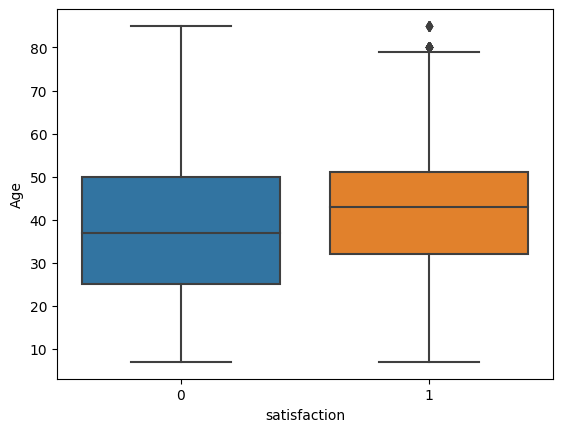

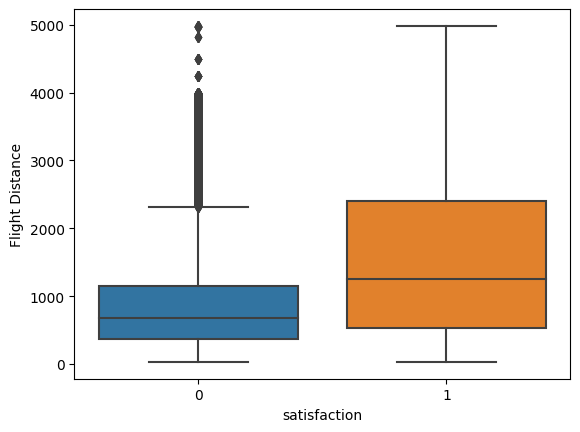

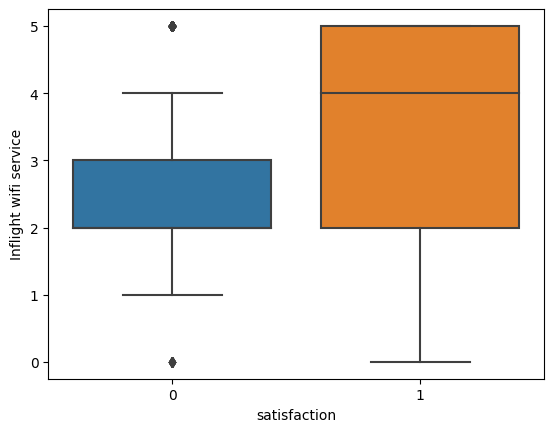

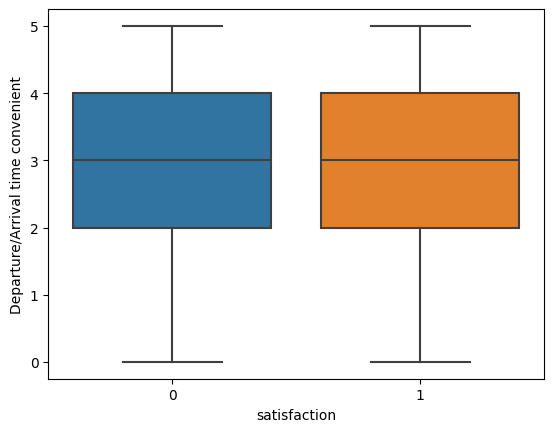

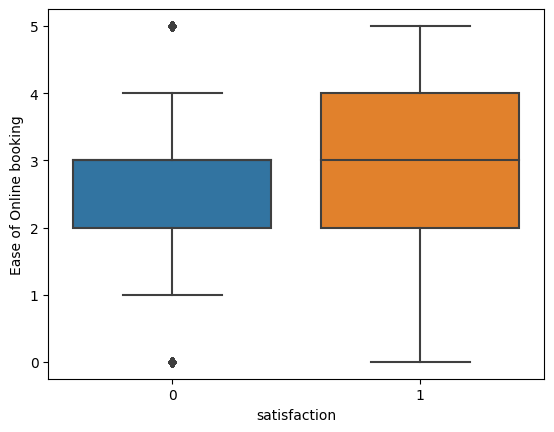

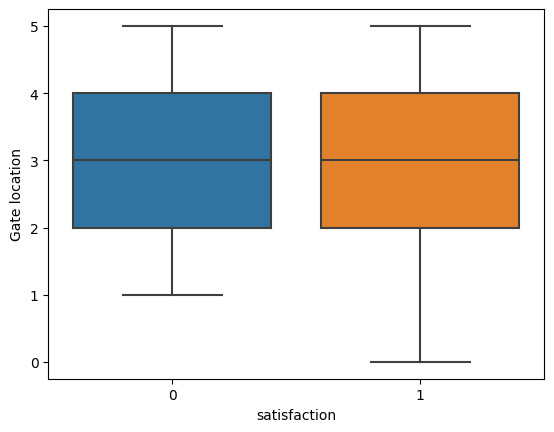

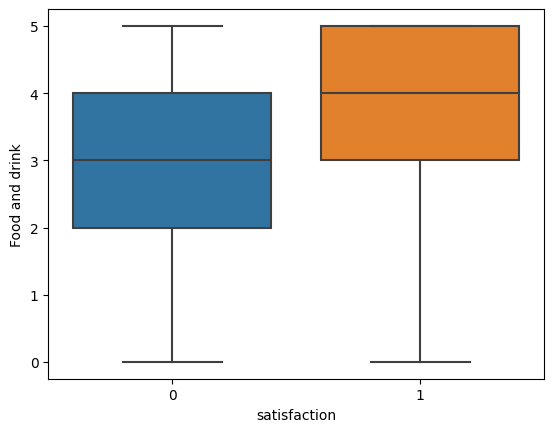

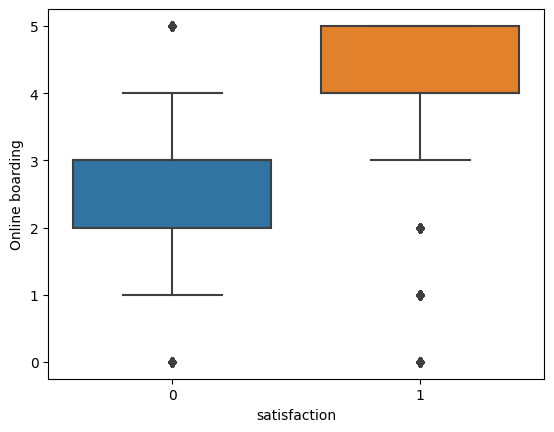

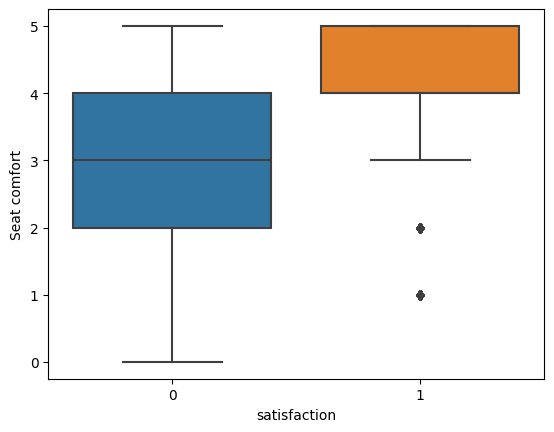

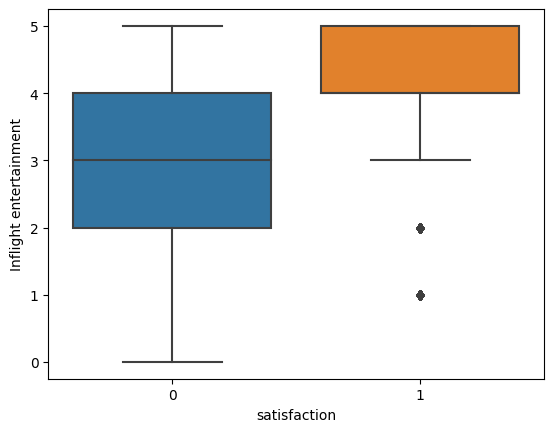

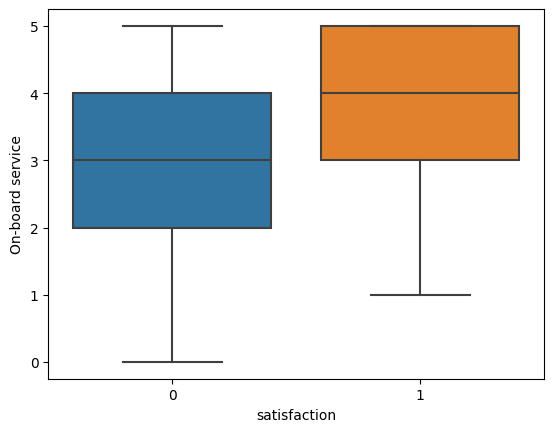

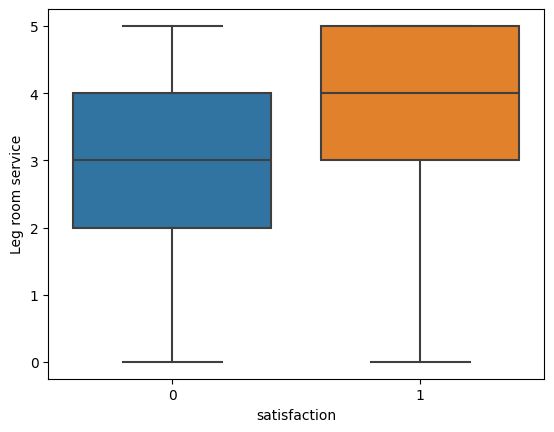

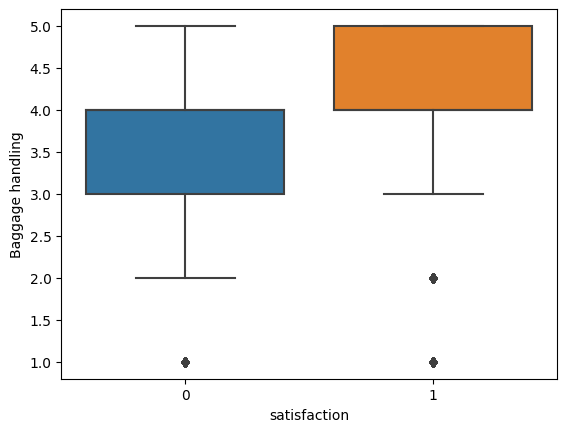

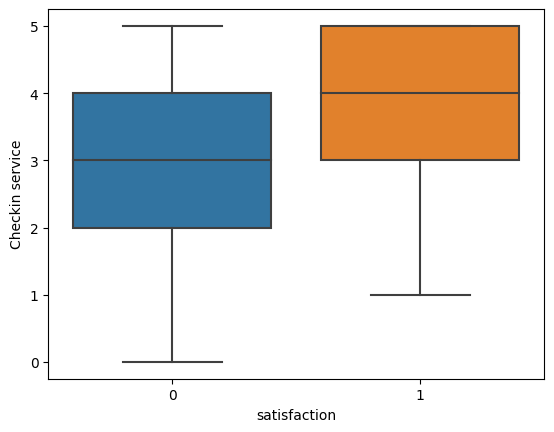

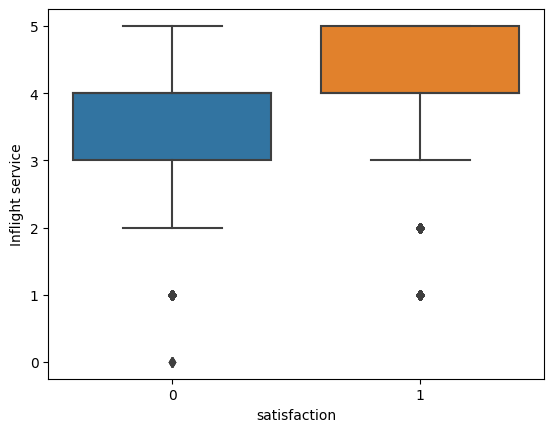

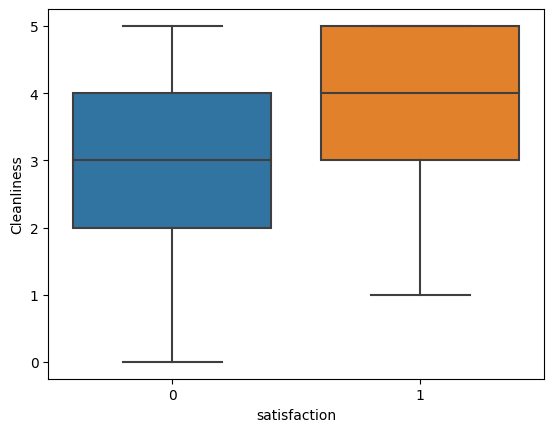

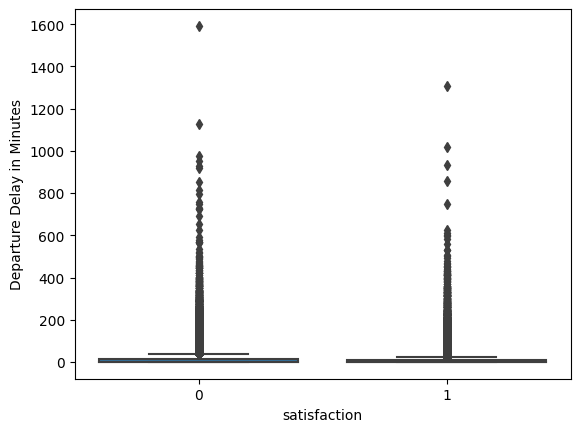

In [141]:
import seaborn as sns
for i in df_nan_cats:
  plt.figure(i)
  sns.boxplot(x=df['satisfaction'],y=df[i])




<ipython-input-142-cd4b6a24e632>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['satisfaction']==0,i],shade=True)
<ipython-input-142-cd4b6a24e632>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['satisfaction']==1,i],shade=True)
<ipython-input-142-cd4b6a24e632>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['satisfaction']==0,i],shade=True)
<ipython-input-142-cd4b6a24e632>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['satisfaction']==1,i],shade=True)


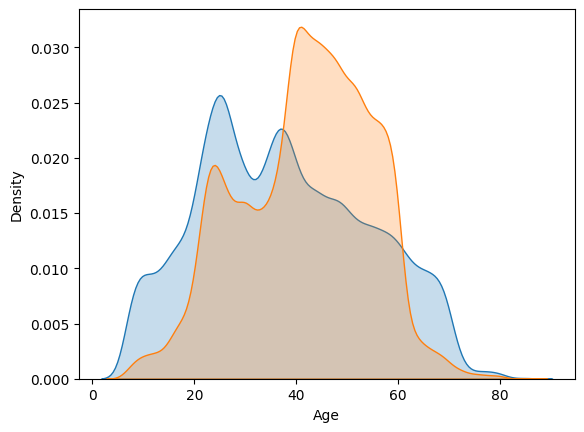

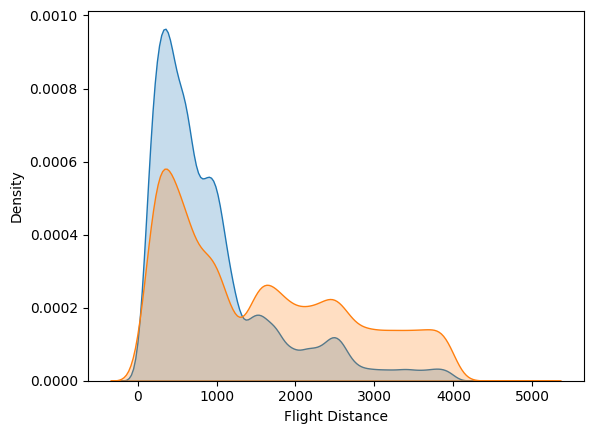

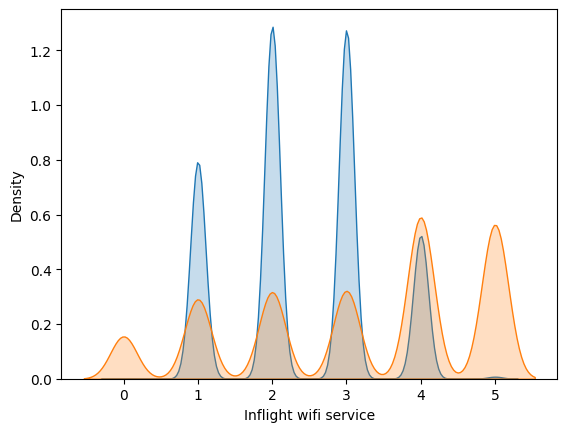

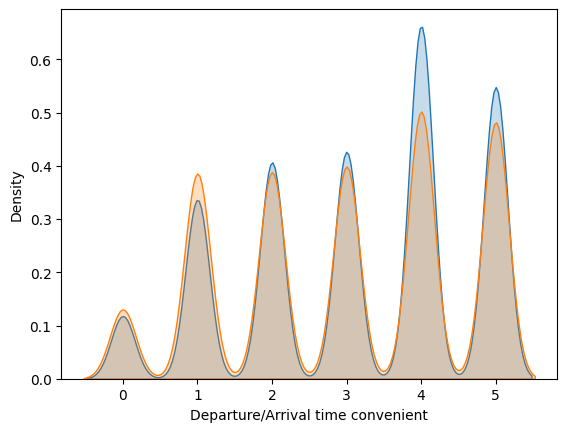

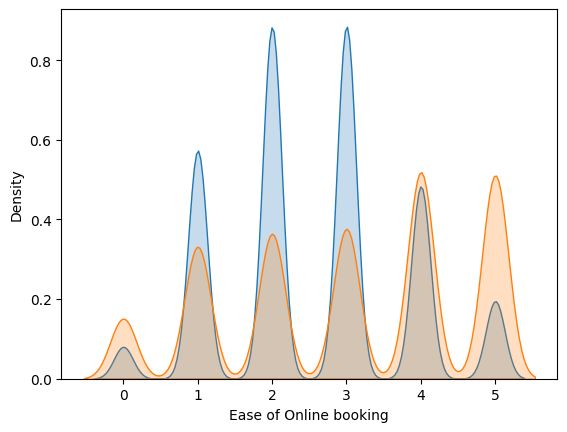

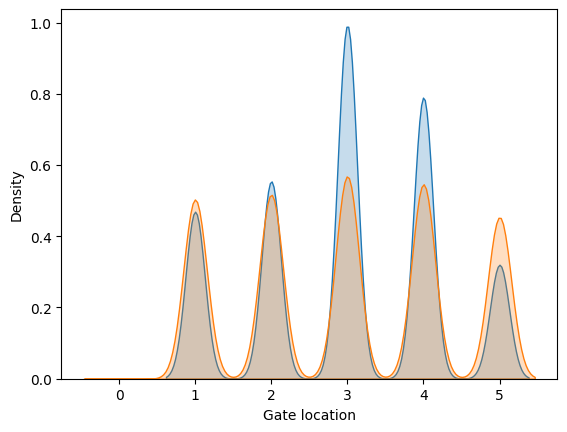

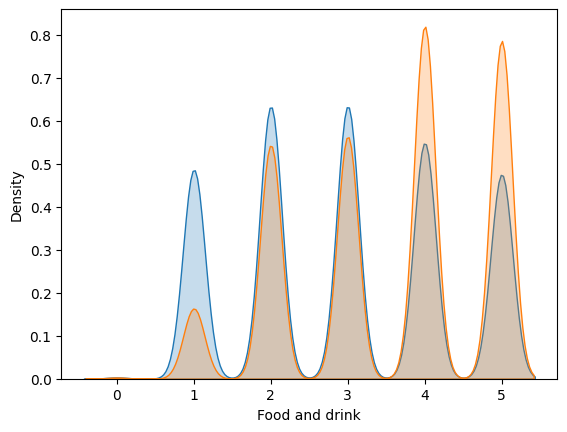

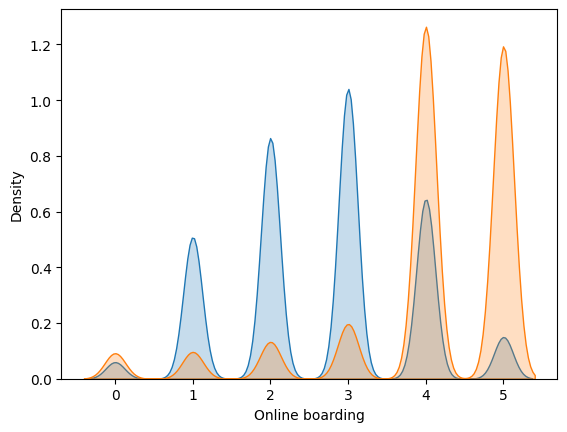

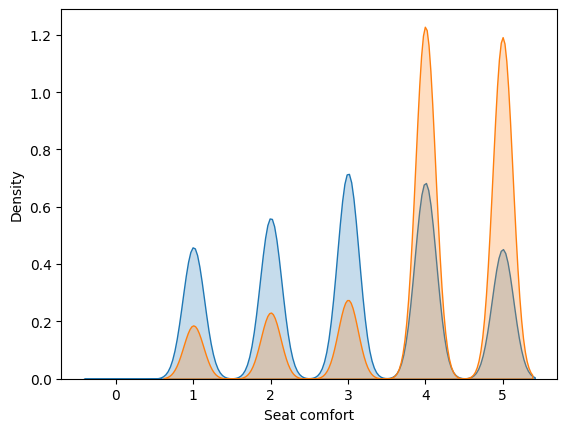

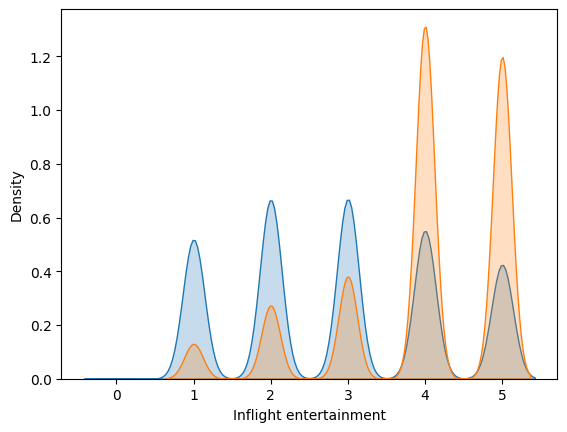

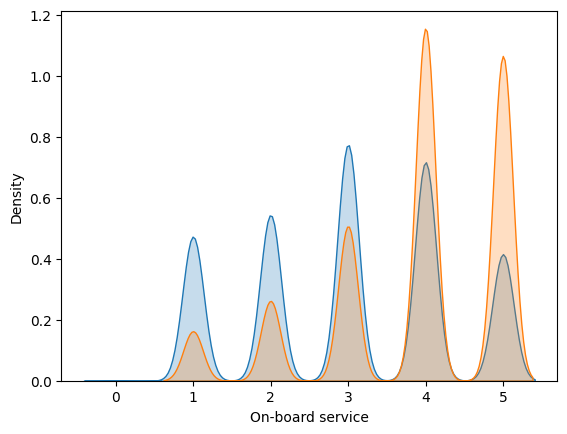

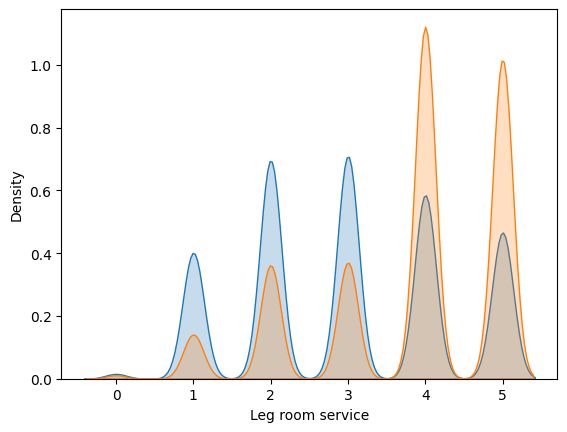

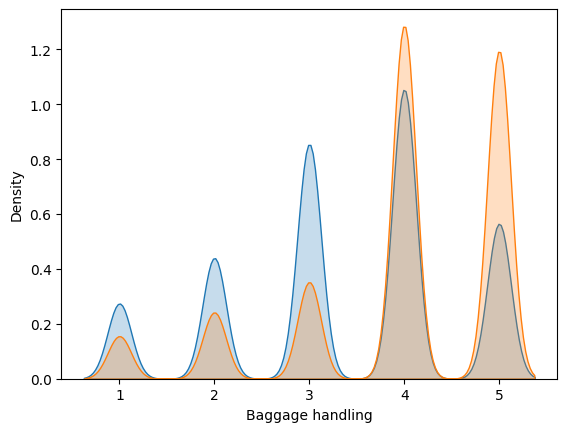

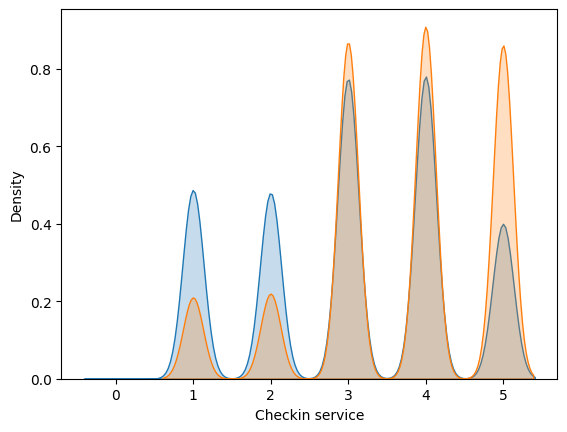

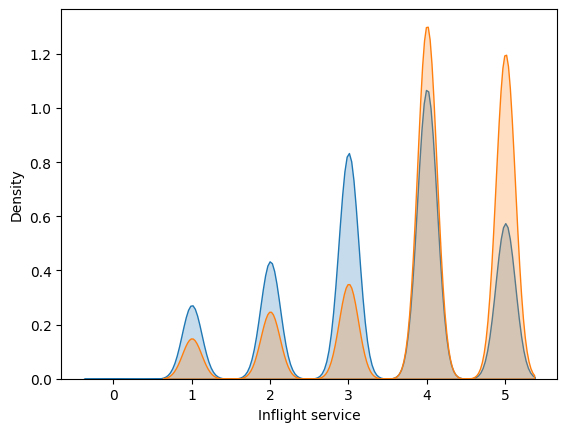

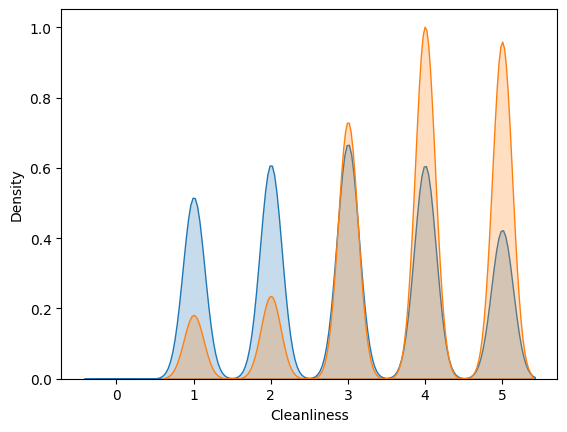

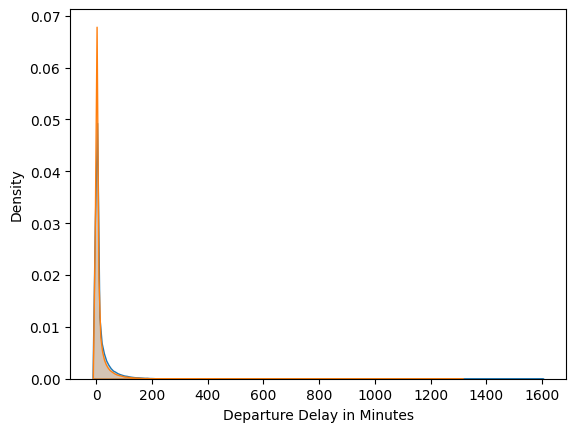

In [142]:
for i in (df_nan_cats):
  plt.figure(i)
  sns.kdeplot(df.loc[df['satisfaction']==0,i],shade=True)
  sns.kdeplot(df.loc[df['satisfaction']==1,i],shade=True)

In [96]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1:]


In [97]:
from sklearn.model_selection import train_test_split

In [98]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=101)


In [99]:
from sklearn.ensemble import RandomForestClassifier
import time


In [100]:
start= time.process_time()
model = RandomForestClassifier(n_estimators=700).fit(X_train,y_train)
passed_time =  time.process_time() - start
preds = model.predict(X_test)
passed_time

<ipython-input-100-cf4480d2e1f5>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(n_estimators=700).fit(X_train,y_train)


77.463017776

In [101]:
from sklearn.metrics import classification_report,confusion_matrix

In [102]:
confusion_matrix(y_test,preds)

array([[14427,   298],
       [  618, 10633]])

In [103]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

Accuracy: 0.964736680012319


In [104]:
import matplotlib.pyplot as plt

<Axes: >

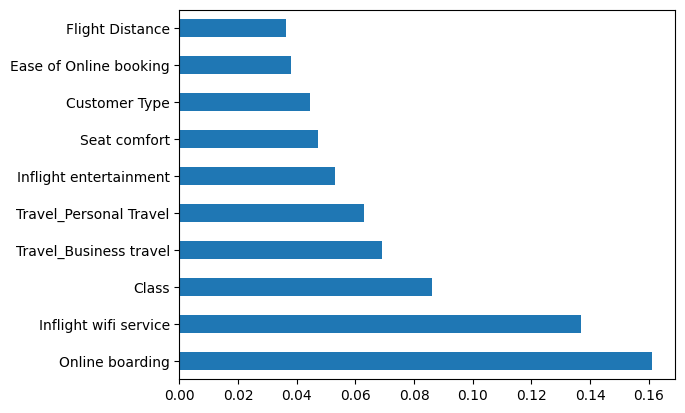

In [105]:
feature_imp = pd.Series(model.feature_importances_,index=X.columns)
feature_imp.nlargest(10).plot(kind='barh')

In [106]:
best_features = feature_imp.nlargest(7).index

In [107]:
X_reduced = X[best_features]
X_reduced

,Online boarding,Inflight wifi service,Class,Travel_Business travel,Travel_Personal Travel,Inflight entertainment,Seat comfort
0,3,3,2,0,1,5,5
1,3,3,3,1,0,1,1
2,5,2,3,1,0,5,5
3,2,2,3,1,0,2,2
4,5,3,3,1,0,3,5
...,...,...,...,...,...,...,...
129875,3,3,3,1,0,4,4
129876,4,4,3,1,0,4,4
129877,1,2,1,0,1,2,2
129878,4,3,3,1,0,4,4


In [109]:
Xr_scaled = MinMaxScaler().fit_transform(X_reduced)
X_train,X_test,y_train,y_test = train_test_split(Xr_scaled,y,test_size=0.2,random_state=101)

In [122]:
start= time.process_time()
model = RandomForestClassifier(n_estimators=700).fit(X_train,y_train)
passed_time =  time.process_time() - start
preds = model.predict(X_test)
passed_time

<ipython-input-122-cf4480d2e1f5>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(n_estimators=700).fit(X_train,y_train)


24.236568006

In [123]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

Accuracy: 0.9313597166615337


In [80]:
def show_outlier(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    lowerrange=Q1-1.5*IQR
    upperrange=Q3+1.5*IQR



    return lowerrange,upperrange

show_outlier(df)

(Gender_Female                          -1.5
 Gender_Male                            -1.5
 Customer Type                           2.0
 Age                                    -9.0
 Travel_Business travel                 -1.5
 Travel_Personal Travel                 -1.5
 Class                                  -2.0
 Flight Distance                     -1581.0
 Inflight wifi service                  -1.0
 Departure/Arrival time convenient      -1.0
 Ease of Online booking                 -1.0
 Gate location                          -1.0
 Food and drink                         -1.0
 Online boarding                        -1.0
 Seat comfort                           -2.5
 Inflight entertainment                 -1.0
 On-board service                       -1.0
 Leg room service                       -1.0
 Baggage handling                        0.0
 Checkin service                         1.5
 Inflight service                        0.0
 Cleanliness                            -1.0
 Departure

In [ ]:
df[df['Inflight wifi service'] < 0]


In [154]:
df[df['Inflight wifi service'] < 0]
df[df['Age'] < 0]

,Gender_Female,Gender_Male,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction


<Axes: >

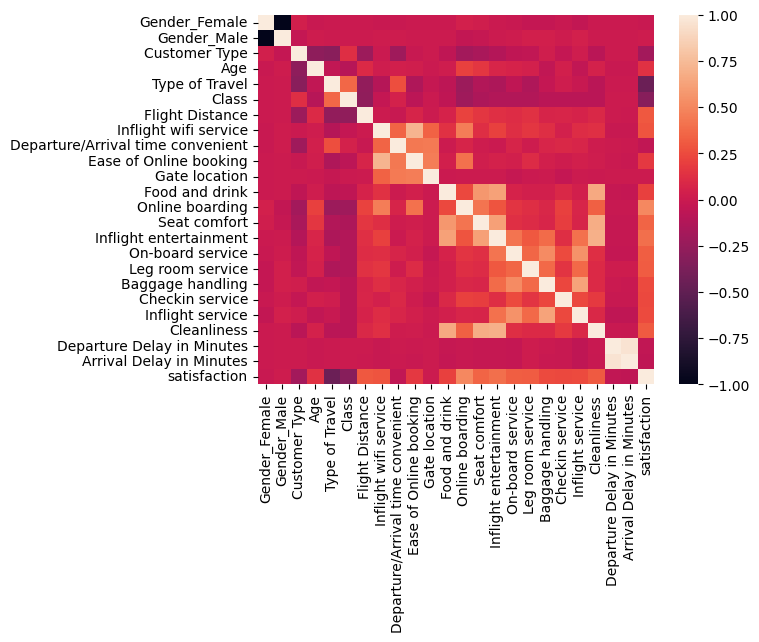

In [163]:
import seaborn as sns

sns.heatmap(df.corr())